In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

%pip install openpyxl

In [ ]:

# Reading the excel file

source_path = Path('/Users/arortega/Desktop/git/world_bank_etl/test_abinveb/data_source/test_source.xlsx')

raw_data_df = pd.read_excel(source_path, sheet_name='P2 - Raw Data')

country_codes_df = pd.read_excel(source_path, sheet_name='Country Codes')


# 0. Notes for the reader:

I've explored and cleaned the data below. You will discover the findings on each section, in addition to further steps I would continue to investigate, which I couldn't complete due to the time restriction.

Hope the results are interesting.

## 1. Data Exploration

In [11]:
raw_data_df.head()

,C1 Ticket Number,Date Received,Date Closed,Customer Informed,Complaint Number,Complaint/Incident,Customer Name,Incoterm,Import Country,Sales Org,...,Accruals Plant [EUR],Accruals ABII [EUR],Amount Accepted Plant [EUR],Amount Accepted ABII [EUR],Amount Accepted ABII [EUR]2,Cost Groups,Unnamed: 52,Unnamed: 53,Currency rate,Unnamed: 55
0,0040488,2016-03-01,2016-06-13,2016-06-13,2016194,Complaint,AB China Sales,FOB,CN,INTERCO,...,0.000000,0.00,0.000000,0.00,0.000000,50,NaN,NaN,GBP-->EUR,1.1838
1,0040435,2016-02-29,2016-06-22,2016-06-22,2016192,Complaint,Labatt,EXW,CA,INTERCO,...,147.179963,0.00,0.000000,0.00,0.000000,50,NaN,NaN,USD-->EUR,0.9149
2,0040684,2016-03-01,2016-04-26,2016-04-26,2016195,Complaint,Labatt,NaN,CA,INTERCO,...,48.535445,0.00,0.000000,0.00,0.000000,50,NaN,NaN,MXN-->EUR,0.04798
3,0039364,2016-02-29,2016-07-12,2016-07-12,2016196,Complaint,CARISAM-SAMUEL MEISEL (FL) INC.,EXW,US,3rd Party,...,74.738181,81.69,74.738181,81.69,6.951819,100,NaN,NaN,NaN,NaN
4,0040432,2016-02-29,2016-06-22,2016-06-22,2016191,Complaint,Labatt,EXW,CA,INTERCO,...,61.499578,0.00,0.000000,0.00,0.000000,50,NaN,NaN,NaN,"TEXT(MONTH(cust.inform.),""mmm""))"


In [13]:
country_codes_df.head()

,code,name,zone
0,AF,Afghanistan,EUR
1,AX,Aland Islands,EUR
2,AL,Albania,EUR
3,DZ,Algeria,Africa
4,AS,American Samoa,APAC


### Basic info:
- Status: a ticket is CLOSED if "Date Closed" and "Customer Informed" are defined, otherwise it's OPEN
- Days to Closure: difference in days between "Date Recevied" and "Date Closed"
- KPI on Closure: 70 if L1 Issue Type="Quality Production", otherwise 50
- WPS Exclusions: Distributors (3rd Party) that have Incoterms either as EXW, FAS or FCA have to be marked as excluded, all the remaining are included

In [ ]:
raw_data_df.info()

# One null in C1 Ticket Number, which probably is the main ID
# Several nulls on Date Closed, perhaps they haven't been closed yet
# Several nulls on Customer Informed, perhaps they match the not closed ones, investigate by Ticket Number
# Check if number of open tickets is the same as number of tickets with Date Closed is Null & Customer Informed is Null
# Check for duplicates on C1 Ticket Number

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1676 entries, 0 to 1675
Data columns (total 56 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   C1 Ticket Number             1675 non-null   object        
 1   Date Received                1676 non-null   datetime64[ns]
 2   Date Closed                  1590 non-null   datetime64[ns]
 3   Customer Informed            1577 non-null   datetime64[ns]
 4   Complaint Number             1676 non-null   int64         
 5   Complaint/Incident           1676 non-null   object        
 6   Customer Name                1676 non-null   object        
 7   Incoterm                     1620 non-null   object        
 8   Import Country               1676 non-null   object        
 9   Sales Org                    1676 non-null   object        
 10  Accepted                     1675 non-null   object        
 11  Complaint Owner              1676 non-null 

In [20]:
raw_data_df.columns

Index(['C1 Ticket Number', 'Date Received', 'Date Closed', 'Customer Informed',
       'Complaint Number', 'Complaint/Incident', 'Customer Name', 'Incoterm',
       'Import Country', 'Sales Org', 'Accepted', 'Complaint Owner', 'Plant',
       'Complaint Type', 'Defect Type', 'Complaint Text', 'Order Number',
       'PO Number', 'Shipment', 'Container Number', 'Brand',
       'Exporting Country', 'SKU', 'SKU Name', 'Quantity', 'VolumeHL',
       'Pack Type', 'L1 Issue Type', 'L2 Issue Type', 'Follow up',
       'Root Cause Category', 'Root Cause Comment2', 'Claimed Amount',
       'Currency', 'ABII Product Cost', 'ABII Extra Fees', 'Accruals ABII',
       'Amount Accepted (ABII)', 'IMD_Currency', 'Plant Product Cost',
       'Plant Extra Fees', 'Accruals Plant', 'PlantAmountAccepted',
       'Currency2', 'BSCCosts', 'Claimed Amount [EUR]', 'Accruals Plant [EUR]',
       'Accruals ABII [EUR]', 'Amount Accepted Plant [EUR]',
       'Amount Accepted ABII [EUR]', 'Amount Accepted ABII [EUR]

## 2. Data Cleaning

In [ ]:
raw_data_df[raw_data_df['C1 Ticket Number'].isnull()]

# I would investigate the source of the missing ticket number. For now I will leave it in there because the record
# provides information about the ticket, even if the number is missing.

,C1 Ticket Number,Date Received,Date Closed,Customer Informed,Complaint Number,Complaint/Incident,Customer Name,Incoterm,Import Country,Sales Org,...,Accruals Plant [EUR],Accruals ABII [EUR],Amount Accepted Plant [EUR],Amount Accepted ABII [EUR],Amount Accepted ABII [EUR]2,Cost Groups,Unnamed: 52,Unnamed: 53,Currency rate,Unnamed: 55
754,NaN,2016-08-23,2016-11-14,2016-11-14,2016735,Complaint,Cervecera Nacional Dominicana,EXW,DO,INTERCO,...,0.0,0.0,0.0,0.0,0.0,50,NaN,NaN,NaN,NaN


In [ ]:
# I will create a new column 'status' to indicate if a ticket is OPEN or CLOSED, it will be needed later for most of
# the calculations.

raw_data_df['status'] = np.where(
    raw_data_df['Date Closed'].notnull() & raw_data_df['Customer Informed'].notnull(),
    'CLOSED',
    'OPEN'
)

raw_data_df['status'].value_counts()

status
CLOSED    1577
OPEN        99
Name: count, dtype: int64

In [ ]:
# The logic works because there are no records with null Date Closed and not null Customer Informed

raw_data_df[raw_data_df['Date Closed'].isnull() & ~(raw_data_df['Customer Informed'].isnull())]

,C1 Ticket Number,Date Received,Date Closed,Customer Informed,Complaint Number,Complaint/Incident,Customer Name,Incoterm,Import Country,Sales Org,...,Accruals ABII [EUR],Amount Accepted Plant [EUR],Amount Accepted ABII [EUR],Amount Accepted ABII [EUR]2,Cost Groups,Unnamed: 52,Unnamed: 53,Currency rate,Unnamed: 55,status


In [ ]:
# Investigating OPEN tickets

raw_data_df[raw_data_df['status'] == 'OPEN']

,C1 Ticket Number,Date Received,Date Closed,Customer Informed,Complaint Number,Complaint/Incident,Customer Name,Incoterm,Import Country,Sales Org,...,Accruals ABII [EUR],Amount Accepted Plant [EUR],Amount Accepted ABII [EUR],Amount Accepted ABII [EUR]2,Cost Groups,Unnamed: 52,Unnamed: 53,Currency rate,Unnamed: 55,status
793,0109895,2016-08-31,NaT,NaT,2016766,Complaint,TOP LINE SRL,FCA,IT,3rd Party,...,7176.28,0.000000,0.00,0.00,10000,NaN,NaN,NaN,NaN,OPEN
901,0355892,2017-05-23,NaT,NaT,2017402,Complaint,STANBEV INTERNATIONAL DISTRIBUT,CIF,LV,3rd Party,...,443.13,0.000000,0.00,0.00,500,NaN,NaN,NaN,NaN,OPEN
902,0365444,2017-05-22,2017-05-30,NaT,2017399,Complaint,Bahrain MM,FCA,BH,3rd Party,...,3785.63,10279.977144,3785.63,0.00,25000,NaN,NaN,NaN,NaN,OPEN
903,0365444,2017-05-22,2017-05-30,NaT,2017399,Complaint,Bahrain MM,FCA,BH,3rd Party,...,76.35,33.130000,76.35,43.22,25000,NaN,NaN,NaN,NaN,OPEN
905,0346424,2017-05-22,NaT,NaT,2017396,Complaint,Nanlien International Corporation,CIF,TW,INTERCO,...,0.00,0.000000,0.00,0.00,50,NaN,NaN,NaN,NaN,OPEN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670,0386634,2017-06-05,NaT,NaT,2017456,Complaint,Asahi,FOB,JP,3rd Party,...,9827.66,0.000000,0.00,0.00,50,NaN,NaN,NaN,NaN,OPEN
1671,0391654,2017-06-07,NaT,NaT,2017458,Complaint,Amvyx,EXW,GR,3rd Party,...,0.00,0.000000,0.00,0.00,50,NaN,NaN,NaN,NaN,OPEN
1673,0000000,2017-06-08,NaT,NaT,2017435,Complaint,Gulf Beverages (African & E),FCA,AE,3rd Party,...,96.32,0.000000,0.00,0.00,300,NaN,NaN,NaN,NaN,OPEN
1674,0000000,2017-06-08,NaT,NaT,2017435,Complaint,Gulf Beverages (African & E),FCA,AE,3rd Party,...,79.44,0.000000,0.00,0.00,300,NaN,NaN,NaN,NaN,OPEN


## 2. Plot the number of tickets received by received date vs the number of tickets closed by closed date. How many tickets were received in May 2017? And how many were closed in May 2017?

In [ ]:
# I calculated the number of tickets received and closed by date.

tickets_received = raw_data_df.groupby(raw_data_df['Date Received'].dt.date).size()
tickets_closed   = raw_data_df.groupby(raw_data_df['Date Closed'].dt.date).size()

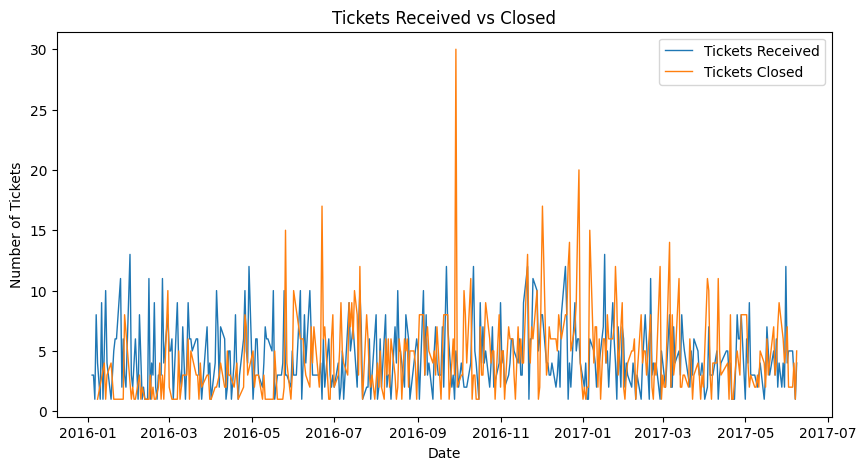

In [ ]:
# Plotting the results, grouping by Tickets Received and Closed

plt.figure(figsize=(10,5))
tickets_received.plot(label='Tickets Received', linewidth=1)
tickets_closed.plot(label='Tickets Closed', linewidth=1)

plt.title('Tickets Received vs Closed')
plt.xlabel('Date')
plt.ylabel('Number of Tickets')
plt.legend()
plt.show()


In [29]:
# How Many were received and close in May 2017

received_may_2017 = raw_data_df[raw_data_df['Date Received'].dt.to_period('M') == '2017-05']
n_received = received_may_2017.shape[0]

closed_may_2017 = raw_data_df[raw_data_df['Date Closed'].dt.to_period('M') == '2017-05']
n_closed = closed_may_2017.shape[0]

print("Tickets opened in May 2017:", n_received)
print("Tickets closed in May 2017:", n_closed)


Tickets opened in May 2017: 94
Tickets closed in May 2017: 95


In [30]:
# Investigate outliers on tickets closed

closed_tickets_df = raw_data_df.groupby('Date Closed').size().reset_index(name='counts')
closed_tickets_df = closed_tickets_df.sort_values(by='counts', ascending=False)
closed_tickets_df.head()

,Date Closed,counts
173,2016-09-29,30
238,2016-12-29,20
219,2016-12-02,17
99,2016-06-22,17
245,2017-01-06,15


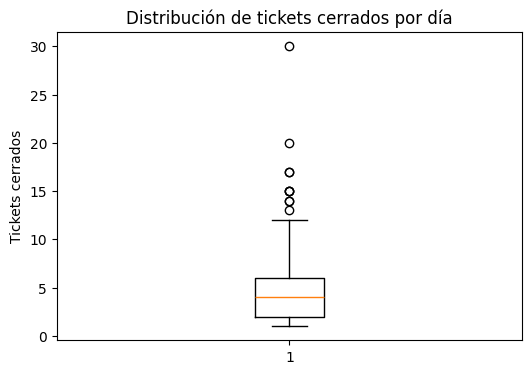

In [ ]:
plt.figure(figsize=(6,4))
plt.boxplot(closed_tickets_df['counts'])
plt.title('Distribution of closed tickets per day')
plt.ylabel('Closed Tickets')
plt.show()

In [ ]:
# Furtherly I would investigate the root of this outlier to understand its cause and impact on the overall analysis,
# and check whether it's an outlier or just a day with a particularly high volume of tickets.

## 3. Plot the number of tickets recevied by export and import zone (you can get it from Country Codes worksheet)

In [ ]:
# Prior to the question, I need to merge the dataframe with the codes one, with a left join, using the country code as
# primary key. I need to do it twice, since it's the same PK and I need to join it in 2 columns (import country & export country)

df_merge = raw_data_df.merge(
    country_codes_df[['code', 'name']],
    left_on='Import Country',
    right_on='code',
    how='left'
).rename(columns={'name': 'Import Country Name'})

df_merge = df_merge.merge(
    country_codes_df[['code', 'name']],
    left_on='Exporting Country',
    right_on='code',
    how='left'
).rename(columns={'name': 'Exporting Country Name'})


In [55]:
# Counting the tickets by Import and Export country
import_tickets = df_merge.groupby('Import Country Name').size().reset_index(name='Import Tickets')
export_tickets = df_merge.groupby('Exporting Country Name').size().reset_index(name='Export Tickets')

# Merging all data into the same DF and renaming the import Country as Country
tickets_by_country = pd.merge(
    import_tickets, 
    export_tickets, 
    left_on='Import Country Name', 
    right_on='Exporting Country Name', 
    how='outer'
).rename(columns={'Import Country Name': 'Country'})

# Filling nulls with 0
tickets_by_country = tickets_by_country[['Country', 'Import Tickets', 'Export Tickets']].fillna(0)


In [57]:
tickets_by_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Country         85 non-null     object 
 1   Import Tickets  85 non-null     int64  
 2   Export Tickets  85 non-null     float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.1+ KB


In [58]:
tickets_by_country['Export Tickets'] = tickets_by_country['Export Tickets'].astype(int)

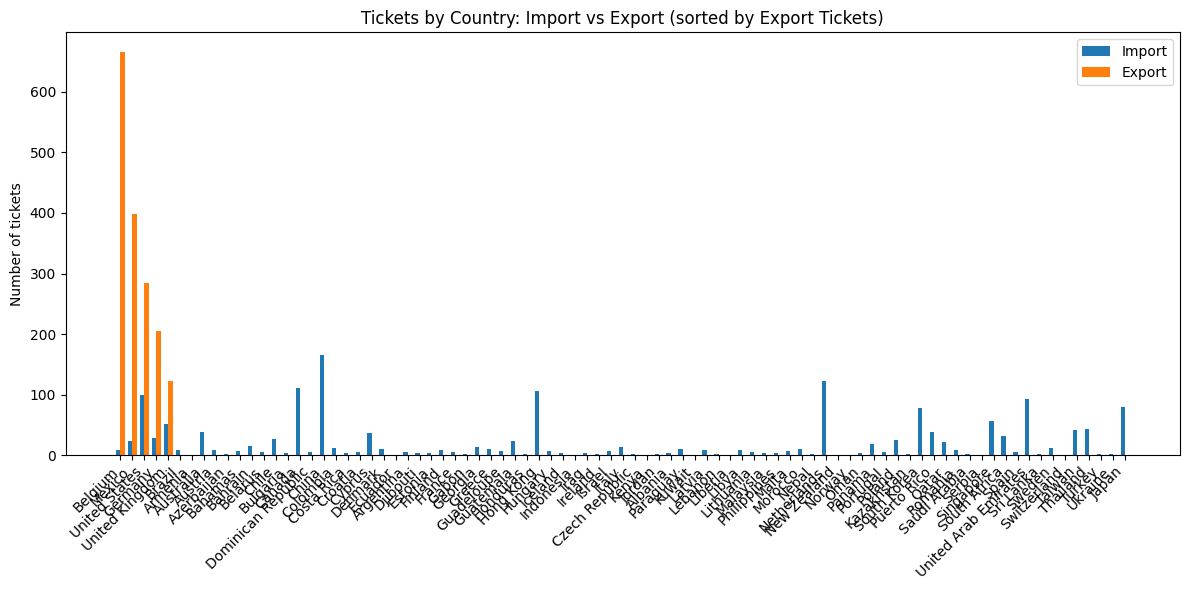

In [62]:
# To better visualize the information, I will plot a double bar graph, each country having 2 different bars for
# tickets per country (import and export)

# Sort countries by number of export tickets, descending
tickets_by_country = tickets_by_country.sort_values('Export Tickets', ascending=False).reset_index(drop=True)

x = np.arange(len(tickets_by_country['Country']))
width = 0.35

plt.figure(figsize=(12,6))

# Bars import/export
plt.bar(x - width/2, tickets_by_country['Import Tickets'], width, label='Import')
plt.bar(x + width/2, tickets_by_country['Export Tickets'], width, label='Export')

# Labels
plt.xticks(x, tickets_by_country['Country'], rotation=45, ha='right')
plt.ylabel('Number of tickets')
plt.title('Tickets by Country: Import vs Export (sorted by Export Tickets)')
plt.legend()
plt.tight_layout()
plt.show()


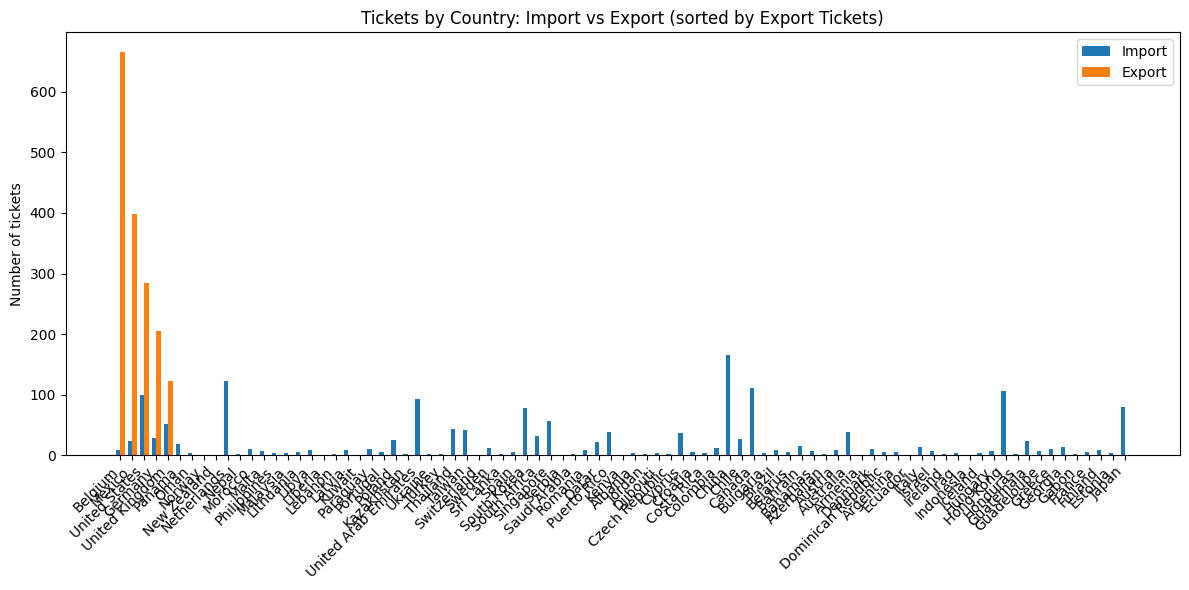

In [61]:
# Ordenar por Export Tickets descendente
tickets_by_country = tickets_by_country.sort_values('Export Tickets', ascending=False).reset_index(drop=True)

# Eje X
x = np.arange(len(tickets_by_country['Country']))
width = 0.35

plt.figure(figsize=(12,6))

# Barras import/export
plt.bar(x - width/2, tickets_by_country['Import Tickets'], width, label='Import')
plt.bar(x + width/2, tickets_by_country['Export Tickets'], width, label='Export')

# Labels
plt.xticks(x, tickets_by_country['Country'], rotation=45, ha='right')
plt.ylabel('Number of tickets')
plt.title('Tickets by Country: Import vs Export (sorted by Export Tickets)')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# I would investigate why there's such a large discrepancy between import and export tickets for certain countries
# like Belgium, Mexico, US and Germany

## 3. Plot the volume in HL of the tickets by received date vs the volume in HL by closed date in 2016

In [ ]:
# Checking nulls for Volume

df_merge['VolumeHL'].isnull().sum()

np.int64(5)

In [ ]:
# Merging all data for 2016, filtering that all received and closed dates are in 2016
# Filling the NA values

df_2016 = df_merge[
    (df_merge['Date Received'].dt.year == 2016) &
    (df_merge['Date Closed'].dt.year == 2016)
]

df_2016['VolumeHL'].fillna(0, inplace=True)

/var/folders/6k/zfk3kxb1447czyrbwnhwzgsw0000gn/T/ipykernel_3453/936746588.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_2016['VolumeHL'].fillna(0, inplace=True)
/var/folders/6k/zfk3kxb1447czyrbwnhwzgsw0000gn/T/ipykernel_3453/936746588.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2016['VolumeHL'].fillna(0, inplace=True)


In [ ]:
# Calculating the volume received
volume_received = df_2016.groupby('Date Received')['VolumeHL'].sum().reset_index()

# Calculating the volume closed
volume_closed = df_2016.groupby('Date Closed')['VolumeHL'].sum().reset_index()


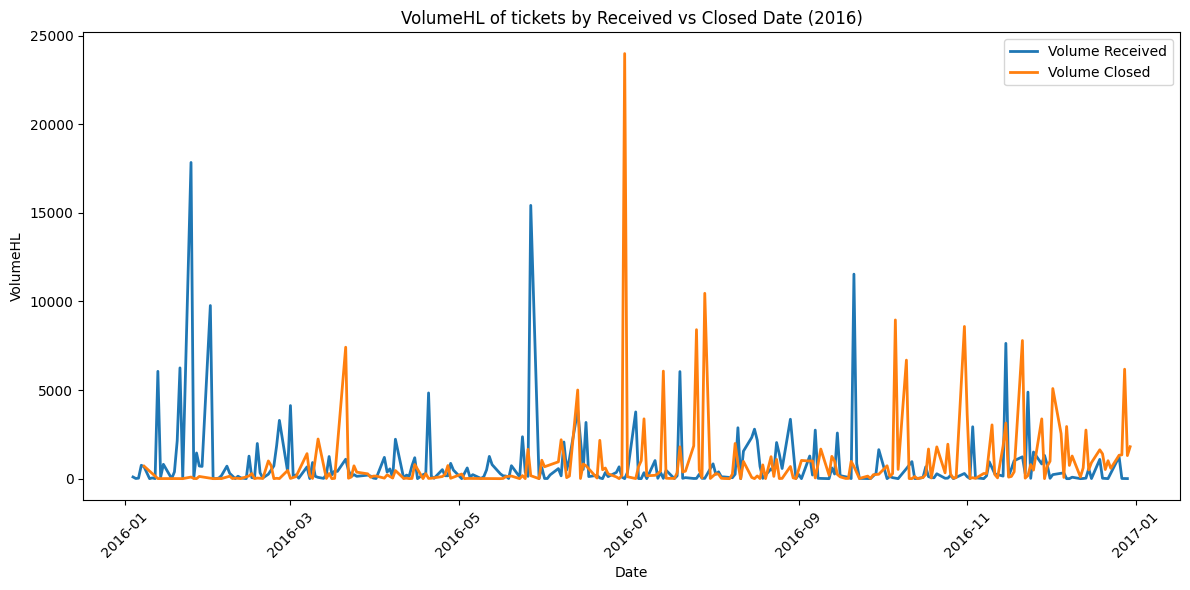

In [ ]:
# Plotting the results

plt.figure(figsize=(12,6))

plt.plot(volume_received['Date Received'], volume_received['VolumeHL'], label='Volume Received', linewidth=2)
plt.plot(volume_closed['Date Closed'], volume_closed['VolumeHL'], label='Volume Closed', linewidth=2)

plt.title('VolumeHL of tickets by Received vs Closed Date (2016)')
plt.xlabel('Date')
plt.ylabel('VolumeHL')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [ ]:
# I would investigate further why there are so many closed tickets in July, if it's something sesonal or an anomaly

## 4. Plot the number of tickets received of the TOP5 Brands by Volume in HL

In [ ]:
# As for the question following this one, I will group by the Brand (Customer Name) and select the ones on the top 5
# index

top5_brands = df_merge.groupby('Customer Name')['VolumeHL'].sum().nlargest(5).index

df_top5 = df_merge[df_merge['Customer Name'].isin(top5_brands)]

tickets_by_brand = df_top5.groupby('Customer Name').size().reset_index(name='Tickets Received')

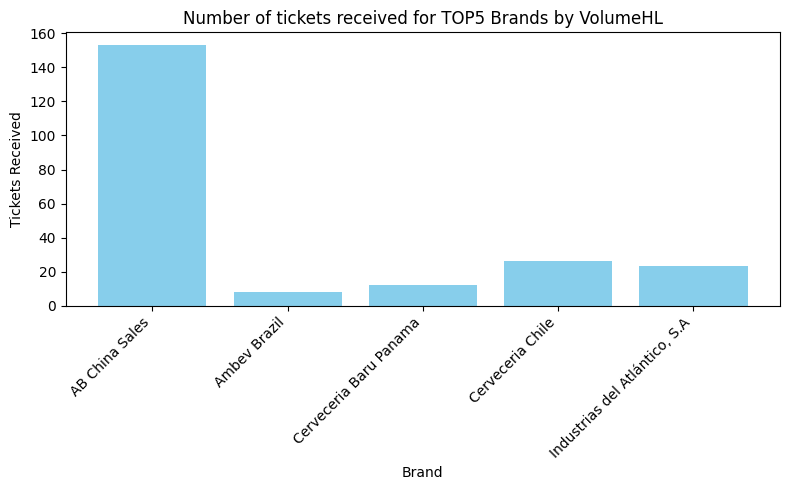

In [ ]:
# Plotting the results

plt.figure(figsize=(8,5))
plt.bar(tickets_by_brand['Customer Name'], tickets_by_brand['Tickets Received'], color='skyblue')
plt.title('Number of tickets received for TOP5 Brands by VolumeHL')
plt.xlabel('Brand')
plt.ylabel('Tickets Received')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# I would investigate why AB China has so many received tickets by Volume HL

## 5. Plot the number of tickets received of the TOP5 Import countries by Volume in HL

In [ ]:
# Same logic as for above, grouping by the Country name of the top 5 by volume HL

top5_import_countries = df_merge.groupby('Import Country Name')['VolumeHL'].sum().nlargest(5).index

df_top5_import = df_merge[df_merge['Import Country Name'].isin(top5_import_countries)]

tickets_by_import_country = df_top5_import.groupby('Import Country Name').size().reset_index(name='Tickets Received')


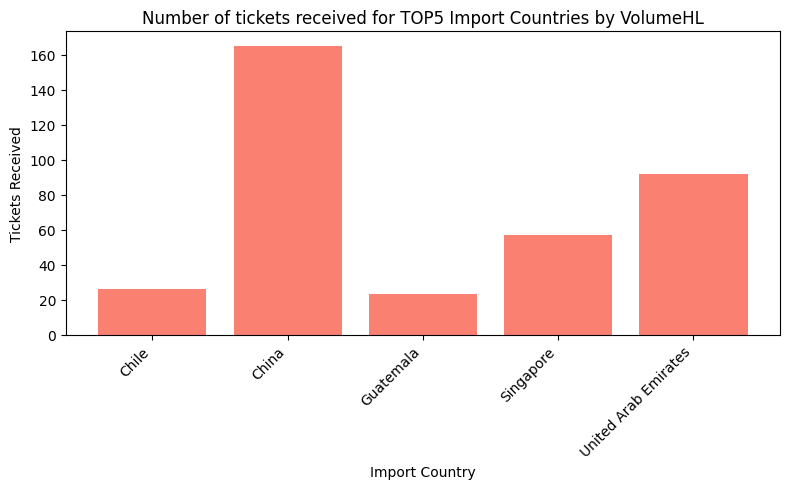

In [ ]:
# Plotting the results

plt.figure(figsize=(8,5))
plt.bar(tickets_by_import_country['Import Country Name'], tickets_by_import_country['Tickets Received'], color='salmon')
plt.title('Number of tickets received for TOP5 Import Countries by VolumeHL')
plt.xlabel('Import Country')
plt.ylabel('Tickets Received')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [ ]:
# There's clearly a pattern here. We can see that China has a great volume of tickets received by Volume, either by
# Country itself of by one of their Brands.